# Loading and analyzing data from files

We look at how to:

1. **Load data** from files (e.g. Excel or CSV). 
2. **Clean, structure and analyze data**.
3. **Save data** to files (e.g. Excel or CSV).

**Table of contents**<a id='toc0_'></a>    
- 1. [Employment rate in Danish municipalities](#toc1_)    
  - 1.1. [Step 1: Look at the file](#toc1_1_)    
  - 1.2. [Step 2: Clean up](#toc1_2_)    
    - 1.2.1. [Skip rows and drop columns](#toc1_2_1_)    
    - 1.2.2. [Renaming variables](#toc1_2_2_)    
    - 1.2.3. [Dropping non-municipalities](#toc1_2_3_)    
    - 1.2.4. [Summary statistics](#toc1_2_4_)    
  - 1.3. [Step 3. Structure](#toc1_3_)    
- 2. [Employment and participation rate in Danish municipalities](#toc2_)    
- 3. [Income in Danish municipalities](#toc3_)    
- 4. [Area in Danish municipalities](#toc4_)    
- 5. [Writing data](#toc5_)    
- 6. [Summary](#toc6_)    
- 7. [More on `pivot_table`](#toc7_)    
  - 7.1. [Example 1: Starting from a fully long dataset](#toc7_1_)    
  - 7.2. [Example 2: Starting from a long dataset with wide years](#toc7_2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import os 

import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams.update({'axes.grid':True,'grid.color':'black','grid.alpha':'0.25','grid.linestyle':'--'})
plt.rcParams.update({'font.size': 14})

Pandas offers a lot of facilities for **reading and writing to different formats**. The functions have logical names: 

* Excel: `pd.read_excel()`
* CSV: `pd.read_csv()`
* SAS: `pd.read_sas()`
* Stata: `pd.read_stata()`
* Parquet: `pd.read_parquet()`

And many more... 

**Example:** Raw downloads of Excel-files from [DST](https://www.statbank.dk/statbank5a/SelectTable/Omrade0.asp?PLanguage=1)  

In [2]:
# using assert to check that paths exist on computer.
assert os.path.isdir('data/')
assert os.path.isdir('data/raw')

# print everything in data/raw
os.listdir('data/raw/')

['ARE207.xlsx',
 'INDKP101.xlsx',
 'RAS200.xlsx',
 'RAS200_only_employment_rate.xlsx']

## 1. <a id='toc1_'></a>[Employment rate in Danish municipalities](#toc0_)

### 1.1. <a id='toc1_1_'></a>[Step 1: Look at the file](#toc0_)

Open the file and have a look at it:

In [3]:
filename = 'data/raw/RAS200_only_employment_rate.xlsx'
pd.read_excel(filename).iloc[:5,:7] # 5 rows, 7 columns

,"Activity and employment rates (end November) by frequency, sex, age, ancestry, region and time",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,Units: Per cent,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,2008.0,2009.0
2,Employment rate,Total,16-64 years,Total,All Denmark,76.0,72.8
3,NaN,NaN,NaN,NaN,Region Hovedstaden,75.8,73.3
4,NaN,NaN,NaN,NaN,Province Byen København,73.4,71.0


### 1.2. <a id='toc1_2_'></a>[Step 2: Clean up](#toc0_)

We need to clean this *mess* up.

#### 1.2.1. <a id='toc1_2_1_'></a>[Skip rows and drop columns](#toc0_)

**Skipping rows:** Clearly, we should **skip** the first three rows and the first four columns

In [4]:
RAS = pd.read_excel(filename,skiprows=2)
RAS.iloc[:5,:7]

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,2008,2009
0,Employment rate,Total,16-64 years,Total,All Denmark,76.0,72.8
1,NaN,NaN,NaN,NaN,Region Hovedstaden,75.8,73.3
2,NaN,NaN,NaN,NaN,Province Byen København,73.4,71.0
3,NaN,NaN,NaN,NaN,Copenhagen,72.5,70.0
4,NaN,NaN,NaN,NaN,Frederiksberg,75.6,73.7


**Dropping columns:** The first couple of columns are not needed and contain only missing values (denoted by `NaN`, not-a-number), so we will drop those. 

In [5]:
drop_cols = ['Unnamed: ' + str(num) for num in range(4)] # use list comprehension to create list of columns
print(f'{drop_cols = }')

RAS = RAS.drop(columns=drop_cols) # axis = 1 -> columns
RAS.iloc[:5,:5]

drop_cols = ['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3']


,Unnamed: 4,2008,2009,2010,2011
0,All Denmark,76.0,72.8,72.1,71.8
1,Region Hovedstaden,75.8,73.3,72.6,72.5
2,Province Byen København,73.4,71.0,70.5,70.5
3,Copenhagen,72.5,70.0,69.7,69.6
4,Frederiksberg,75.6,73.7,72.7,72.8


#### 1.2.2. <a id='toc1_2_2_'></a>[Renaming variables](#toc0_)

We are not happy with the column comprising regions, which is currently called `Unnamed: 4`.   

In [6]:
RAS = RAS.rename(columns={'Unnamed: 4':'municipality'})
RAS.iloc[:5,:5]

,municipality,2008,2009,2010,2011
0,All Denmark,76.0,72.8,72.1,71.8
1,Region Hovedstaden,75.8,73.3,72.6,72.5
2,Province Byen København,73.4,71.0,70.5,70.5
3,Copenhagen,72.5,70.0,69.7,69.6
4,Frederiksberg,75.6,73.7,72.7,72.8


**Rename all year columns:** We also see that the employment rate in 2008 has been named `2008`.   

This is allowed in Python, but having a **variable named as a number** can cause **problems** with some functions.

To change all columns, we need to create a dictionary that maps each of the years {2008, ..., 2013} to {emp_rate2008, ...,emp_rate2013}. 

In [7]:
col_dict = {str(i) : f'emp_rate{i}' for i in RAS.columns[1:]}

In [8]:
RAS = RAS.rename(columns=col_dict)
RAS.head(5).iloc[:,0:5]

,municipality,emp_rate2008,emp_rate2009,emp_rate2010,emp_rate2011
0,All Denmark,76.0,72.8,72.1,71.8
1,Region Hovedstaden,75.8,73.3,72.6,72.5
2,Province Byen København,73.4,71.0,70.5,70.5
3,Copenhagen,72.5,70.0,69.7,69.6
4,Frederiksberg,75.6,73.7,72.7,72.8


**Note:** It is a good idea *not* to put *white spaces* in column names. You can theoretically have a column such as RAS['emp_rate 2017'] in a pandas df, but this is *very likely* to get messy. And you can no longer use `.`notation. 

**Extract:** Now we can find the employment rate in the municipality of Copenhagen: 

In [9]:
RAS.loc[RAS.municipality == 'Copenhagen'].iloc[:,0:5]

,municipality,emp_rate2008,emp_rate2009,emp_rate2010,emp_rate2011
3,Copenhagen,72.5,70.0,69.7,69.6


#### 1.2.3. <a id='toc1_2_3_'></a>[Dropping non-municipalities](#toc0_)

The dataset contains observations like "Region Hovedstaden", which is not a municipality, so we want to drop such rows. To do this, we can use the `df['var'].str` functionalities. These are all sorts of functions that work with strings, in particular searching for instances of specific content by `df['var'].str.contains('PATTERN')`. 

In [10]:
# build up a logical index I
I = RAS.municipality.str.contains('Region')
I |= RAS.municipality.str.contains('Province')
I |= RAS.municipality.str.contains('All Denmark')
RAS.loc[I,:].iloc[:5,:5]

,municipality,emp_rate2008,emp_rate2009,emp_rate2010,emp_rate2011
0,All Denmark,76.0,72.8,72.1,71.8
1,Region Hovedstaden,75.8,73.3,72.6,72.5
2,Province Byen København,73.4,71.0,70.5,70.5
7,Province Københavns omegn,77.1,74.2,73.2,73.0
21,Province Nordsjælland,79.4,76.9,76.3,76.1


**Delete these rows:**

In [11]:
RAS = RAS.loc[I==False] # keep everything else
RAS.iloc[:5,:5]

,municipality,emp_rate2008,emp_rate2009,emp_rate2010,emp_rate2011
3,Copenhagen,72.5,70.0,69.7,69.6
4,Frederiksberg,75.6,73.7,72.7,72.8
5,Dragør,80.5,78.8,78.5,78.5
6,Tårnby,79.0,76.3,75.4,75.8
8,Albertslund,73.1,69.2,67.5,67.4


We can sort and reset index so it don't have holes: 

In [12]:
RAS = RAS.sort_values('municipality').reset_index(drop=True) # drop=True to avoid adding old index as a column
RAS.iloc[:5,:5]

,municipality,emp_rate2008,emp_rate2009,emp_rate2010,emp_rate2011
0,Aabenraa,74.6,71.6,70.9,70.2
1,Aalborg,73.2,70.1,69.7,69.2
2,Aarhus,72.6,69.8,69.0,68.0
3,Albertslund,73.1,69.2,67.5,67.4
4,Allerød,83.8,81.5,81.4,80.5


#### 1.2.4. <a id='toc1_2_4_'></a>[Summary statistics](#toc0_)

To get an overview of employments across municipalities we can use the function `df.describe()`.

In [13]:
RAS.iloc[:,:5].describe().style.format('{:.1f}')

,emp_rate2008,emp_rate2009,emp_rate2010,emp_rate2011
count,99.0,99.0,99.0,99.0
mean,76.6,73.4,72.8,72.6
std,3.7,3.6,3.6,3.7
min,62.9,63.4,62.4,61.5
25%,74.7,71.3,70.5,70.0
50%,76.8,73.3,72.9,72.6
75%,79.2,75.9,75.2,75.0
max,84.0,81.5,81.4,80.5


### 1.3. <a id='toc1_3_'></a>[Step 3. Structure](#toc0_)

Think of a dataset as having:

1. `id`, here `municipality`.
1. `period`, here `year`.
1. `variables`, here `empl`(oyment)

Datasets are:

1. **Longer** if they have more *rows*
1. **Wider** if they have more *columns*

In economics, we often like panel data sets, which are:

1. **Wide** in `variables` (i.e. one column, one variable)
1. **Long** in (`id`,`period`) (i.e. one row per observation)

Conversion can be done with `pd.wide_to_long`:

1. `i` is `id`
1. `j` is `period`
1. The wide format variables are assumed to start with the `stubnames`.

In [14]:
RAS_long = pd.wide_to_long(RAS,stubnames='emp_rate',i='municipality',j='year')
RAS_long.head(5)

,,emp_rate
municipality,year,
Aabenraa,2008,74.6
Aalborg,2008,73.2
Aarhus,2008,72.6
Albertslund,2008,73.1
Allerød,2008,83.8


In [15]:
RAS_long.tail(5)

,,emp_rate
municipality,year,
Vejle,2023,79.4
Vesthimmerlands,2023,77.4
Viborg,2023,78.0
Vordingborg,2023,74.7
Ærø,2023,73.5


**Note:** The variables `municipality` and `year`  are now in the index!! We see that because they are "below" `empl` in the `head` overview. 

In [16]:
# the index variable now consists of tuples. 
print(RAS_long.index.values[:3])

[('Aabenraa', 2008) ('Aalborg', 2008) ('Aarhus', 2008)]


The index is now a [Multiindex](https://pandas.pydata.org/docs/user_guide/advanced.html#multiindex-advanced-indexing), as it has multiple levels.

We can **select a specific municipality** using ``.xs``:

In [17]:
RAS_long.xs('Roskilde',level='municipality')

,emp_rate
year,
2008,79.1
2009,76.3
2010,75.2
2011,74.9
2012,74.1
2013,74.0
2014,74.0
2015,74.5
2016,75.6


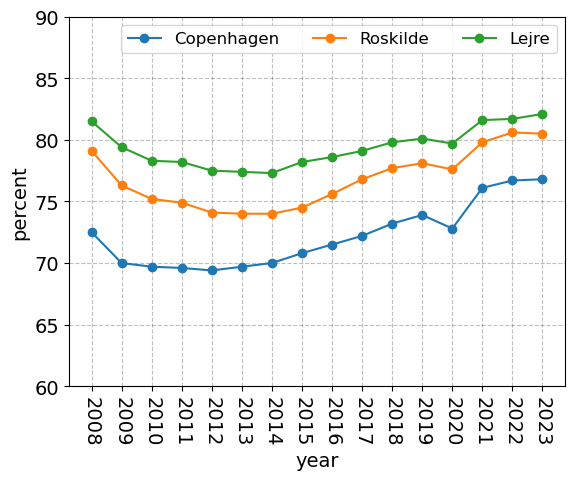

In [18]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

municipalities = ['Copenhagen','Roskilde','Lejre']
for m in municipalities:
    y = RAS_long.xs(m,level='municipality')
    ax.plot(y.index,y['emp_rate'],ls='-',marker='o',label=m)

ax.set_ylabel('percent');
ax.set_ylim([60,90])

ax.set_xlabel('year')
ax.set_xticks(y.index,labels=y.index)
ax.set_xticklabels(y.index,rotation=270)

ax.legend(frameon=True,ncol=3,fontsize=12);

**More genaral alternative for wide-to-long:**

In [19]:
RAS_long_ = RAS.melt(id_vars='municipality',var_name='year',value_name='emp_rate')
RAS_long_['year'] = RAS_long_['year'].str.replace('emp_rate','').astype(int)
RAS_long_.head(5)

,municipality,year,emp_rate
0,Aabenraa,2008,74.6
1,Aalborg,2008,73.2
2,Aarhus,2008,72.6
3,Albertslund,2008,73.1
4,Allerød,2008,83.8


## 2. <a id='toc2_'></a>[Employment and participation rate in Danish municipalities](#toc0_)

We now read in RAS data for *both* the employment rate and the participation rate in each municipality.

Here we do the cleaning, renaming and structuring more condensed.

In [20]:
# a. load
RAS = pd.read_excel('data/raw/RAS200.xlsx',skiprows=2)
print('initial:')
display(RAS.head(5).iloc[:,0:7])

# b. clean and rename
RAS = RAS.drop(columns=[f'Unnamed: {i}' for i in range(3)])

RAS = RAS.rename(columns = {'Unnamed: 3':'variable', 'Unnamed: 4':'municipality'})
years = [col for col in RAS.columns if col.isnumeric()]
RAS = RAS.rename(columns = {str(i): f'value{i}' for i in years})

# c. fill missing
RAS['variable'] = RAS['variable'].ffill()
RAS['variable'] = RAS['variable'].str.replace('Employment rate','emp_rate')
RAS['variable'] = RAS['variable'].str.replace('Economic activity rate','part_rate')

# d. drop rows with missing values - denoted na
RAS = RAS.dropna()

# e. remove non-municipalities
for val in ['Region','Province', 'All Denmark']: 
    I = RAS.municipality.str.contains(val)
    RAS = RAS.drop(RAS[I].index) # .index -> get the indexes of the series
    
print('cleaned:')
RAS.iloc[:5,:5]

initial:


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,2008,2009
0,Total,16-64 years,Total,Employment rate,All Denmark,76.0,72.8
1,NaN,NaN,NaN,NaN,Region Hovedstaden,75.8,73.3
2,NaN,NaN,NaN,NaN,Province Byen København,73.4,71.0
3,NaN,NaN,NaN,NaN,Copenhagen,72.5,70.0
4,NaN,NaN,NaN,NaN,Frederiksberg,75.6,73.7


cleaned:


,variable,municipality,value2008,value2009,value2010
3,emp_rate,Copenhagen,72.5,70.0,69.7
4,emp_rate,Frederiksberg,75.6,73.7,72.7
5,emp_rate,Dragør,80.5,78.8,78.5
6,emp_rate,Tårnby,79.0,76.3,75.4
8,emp_rate,Albertslund,73.1,69.2,67.5


**Convert wide years to long years**:

In [21]:
RAS = pd.wide_to_long(df=RAS,stubnames='value',i=['municipality','variable'],j='year')
RAS.head(5)

value
municipality variable year       
Copenhagen   emp_rate 2008   72.5
                      2009   70.0
                      2010   69.7
                      2011   69.6
                      2012   69.4

**Convert long variables (emp_rate and part_rate) to wide variables:**

In [22]:
RAS = RAS.pivot_table(index=['municipality','year'],columns=['variable'],values='value').rename_axis(None,axis=1)
RAS.head(5)

emp_rate  part_rate
municipality year                     
Aabenraa     2008      74.6       76.3
             2009      71.6       75.2
             2010      70.9       74.5
             2011      70.2       74.0
             2012      69.5       73.7

Compare employment rate and participation rate:

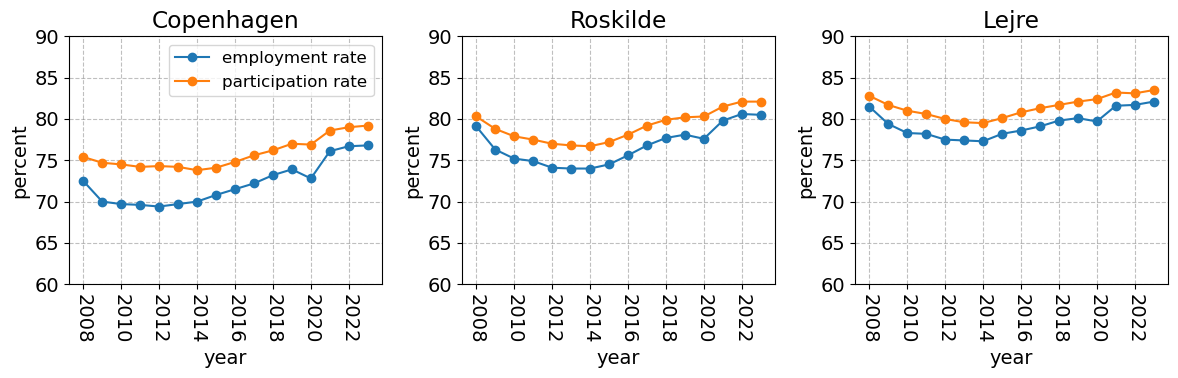

In [23]:
fig = plt.figure(figsize=(12,4))

municipalities = ['Copenhagen','Roskilde','Lejre']
for i,m in enumerate(municipalities):

    ax = fig.add_subplot(1,3,i+1)

    y = RAS.xs(m,level='municipality')
    ax.plot(y.index,y['emp_rate'],ls='-',marker='o',label='employment rate')
    ax.plot(y.index,y['part_rate'],ls='-',marker='o',label='participation rate')

    ax.set_title(m)
    ax.set_ylabel('percent');
    ax.set_ylim([60,90])
    ax.set_xlabel('year')
    ax.set_xticks(y.index[::2])
    ax.set_xticklabels(y.index[::2],rotation=270)
    if i == 0:
        ax.legend(frameon=True,fontsize=12);

fig.tight_layout()

## 3. <a id='toc3_'></a>[Income in Danish municipalities](#toc0_)

We now read in the avg. disposable income in each municipality. 

In [24]:
# a. load
INDKP = pd.read_excel('data/raw/INDKP101.xlsx',skiprows=2)
print('initial:')
display(INDKP.head(5).iloc[:,0:7])

# b. clean and rename
INDKP = INDKP.drop(columns = [f'Unnamed: {i}' for i in range(3)])

INDKP = INDKP.rename(columns = {'Unnamed: 3':'municipality'})
years = [col for col in INDKP.columns if col.isnumeric()]
INDKP = INDKP.rename(columns = {str(i): f'inc{i}' for i in years})

# d. drop rows with missing values - denoted na
INDKP = INDKP.dropna()

# e. remove non-municipalities
for val in ['Region','Province','All Denmark']: 
    I = INDKP.municipality.str.contains(val)
    INDKP = INDKP.drop(INDKP[I].index) # .index -> get the indexes of the series
    
print('cleaned:')
INDKP.iloc[:5,:5]

initial:


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,1987,1988,1989
0,1 Disposable income (2+30-31-32-35),"Men and women, total",Average income for all people (DKK),All Denmark,78135.0,82304.0,87011.0
1,NaN,NaN,NaN,Province Byen København,78012.0,82061.0,85804.0
2,NaN,NaN,NaN,Copenhagen,75356.0,79444.0,82895.0
3,NaN,NaN,NaN,Frederiksberg,85428.0,89924.0,94626.0
4,NaN,NaN,NaN,Dragør,97966.0,99867.0,106167.0


cleaned:


,municipality,inc1987,inc1988,inc1989,inc1990
2,Copenhagen,75356.0,79444.0,82895.0,85421.0
3,Frederiksberg,85428.0,89924.0,94626.0,98916.0
4,Dragør,97966.0,99867.0,106167.0,109441.0
5,Tårnby,87598.0,90789.0,95053.0,98313.0
7,Albertslund,83540.0,87075.0,90616.0,93620.0


**Convert** wide to long:

In [25]:
INDKP = pd.wide_to_long(df=INDKP,stubnames='inc',i='municipality',j='year')
INDKP.head(5)

,,inc
municipality,year,
Copenhagen,1987,75356.0
Frederiksberg,1987,85428.0
Dragør,1987,97966.0
Tårnby,1987,87598.0
Albertslund,1987,83540.0


## 4. <a id='toc4_'></a>[Area in Danish municipalities](#toc0_)

We now read in the area of each municipality in square kilometers. 

In [26]:
# a. load
ARE = pd.read_excel('data/raw/ARE207.xlsx',skiprows=2)
print('initial:')
display(ARE.head(5).iloc[:,0:7])

# b. clean and rename
ARE = ARE.rename(columns = {'Unnamed: 0':'municipality','2008': 'area_2008'})

# c. drop rows with missing values - denoted na
ARE = ARE.dropna()

# d. remove non-municipalities
for val in ['Region','Province','All Denmark']: 
    I = ARE.municipality.str.contains(val)
    ARE = ARE.drop(ARE[I].index) # .index -> get the indexes of the series
    
print('cleaned:')
ARE.iloc[:5,:5]

initial:


,Unnamed: 0,2008
0,All Denmark,43098.31
1,Region Hovedstaden,2561.27
2,Copenhagen,88.25
3,Frederiksberg,8.77
4,Dragør,18.14


cleaned:


,municipality,area_2008
2,Copenhagen,88.25
3,Frederiksberg,8.77
4,Dragør,18.14
5,Tårnby,64.95
6,Albertslund,23.04


## 5. <a id='toc5_'></a>[Writing data](#toc0_)

As with reading in data, we have the corresponding functions for **writing data**:

* CSV: `pd.to_csv()`
* SAS: `pd.to_sas()`
* Excel: `pd.to_excel()`
* Stata: `pd.to_stata()`
* Parquet: `pd.to_parquet()`

Let's **save our dataset to CSV form**. We will set `index=False` to avoid saving the index (which does not mean anything here but can in other contexts be an annoying thing). 

In [27]:
RAS.to_csv('data/RAS200.csv',index=True)
INDKP.to_csv('data/INDKP101.csv',index=True)
ARE.to_csv('data/ARE207.csv',index=False)

## 6. <a id='toc6_'></a>[Summary](#toc0_)

The main takeways are:

- Loading data `pd.read_*` and saving data `pd.to_*`
- Clean data (`.rename`, `.drop`, `.astype`, `.dropna` etc.) 
- Structure data (`.wide_to_long`, `.pivot_table`, `.melt`)
- Multiindex in pandel data (`.xs`)
- Analyzing and plotting data

Any questions on getting and analyzing data from files?

**Socrative room:** PROGECON

## 7. <a id='toc7_'></a>[More on `pivot_table`](#toc0_)

We can change rows to columns and vice-versa.

### 7.1. <a id='toc7_1_'></a>[Example 1: Starting from a fully long dataset](#toc0_)

In [28]:
df_long = pd.DataFrame({
    'id':    [1,1,1,2,2,2],
    'year':  [2023,2023,2024, 2023,2023,2024],
    'metric':['sales','cost','sales', 'sales','cost','sales'],
    'value': [10,6,12, 7,5,9]
})
df_long

,id,year,metric,value
0,1,2023,sales,10
1,1,2023,cost,6
2,1,2024,sales,12
3,2,2023,sales,7
4,2,2023,cost,5
5,2,2024,sales,9


In [29]:
df_long.pivot_table(index=['id','year'],columns='metric',values='value').rename_axis(None,axis=1)

cost  sales
id year             
1  2023   6.0   10.0
   2024   NaN   12.0
2  2023   5.0    7.0
   2024   NaN    9.0

### 7.2. <a id='toc7_2_'></a>[Example 2: Starting from a long dataset with wide years](#toc0_)

In [30]:
df_wide = pd.DataFrame({
    'id':    [1,1,2,2],
    'metric':['sales','cost','sales','cost'],
    'value2023':  [10,6, 7,5],
    'value2024':  [12,None, 9,None]
})
df_wide

,id,metric,value2023,value2024
0,1,sales,10,12.0
1,1,cost,6,NaN
2,2,sales,7,9.0
3,2,cost,5,NaN


First make fully long:

In [31]:
df_long = pd.wide_to_long(df=df_wide,stubnames=['value'],i=['id','metric'],j='year')
df_long

value
id metric year       
1  sales  2023   10.0
          2024   12.0
   cost   2023    6.0
          2024    NaN
2  sales  2023    7.0
          2024    9.0
   cost   2023    5.0
          2024    NaN

Then make wide in variables:

In [32]:
df_long.pivot_table(index=['id','year'],columns='metric',values='value').rename_axis(None,axis=1)

cost  sales
id year             
1  2023   6.0   10.0
   2024   NaN   12.0
2  2023   5.0    7.0
   2024   NaN    9.0